### Loading our data

For the following exercise we will use the word count matrix representation and only use a small subset of our data since we will implement a naiveBayes classifier - which is a "lazy learner" and so predictions will be rather slow.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools

classes_en = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
train_en = pd.read_csv("https://raw.githubusercontent.com/michabirklbauer/hgb_dse_text_mining/master/data/AGNews/train.csv", 
                       names = ["Label", "Title", "Article"],
                       encoding = "utf-8")
test_en = pd.read_csv("https://raw.githubusercontent.com/michabirklbauer/hgb_dse_text_mining/master/data/AGNews/test.csv", 
                      names = ["Label", "Title", "Article"],
                      encoding = "utf-8")

sample = train_en.sample(100)

### Splitting data into a training dataset and a test dataset

*Note:* Data splitting should be your first step in any data science project that involves some kind of machine learning, doing transformations - even something like word counts - will inherently introduce bias and make the calculated generalization error on the test datast less meaningful!

In [2]:
train, test = train_test_split(sample, test_size = 0.35, random_state = 1337)
print(train.shape)
print(test.shape)
train.head()

(65, 3)
(35, 3)


,Label,Title,Article
69157,3,"Dow Slides to Year Low on Oil, Microsoft",NEW YORK (Reuters) - The blue-chip Dow closed...
71930,4,Astronaut Candidates Taste Zero G,NASA #39;s newest astronaut candidates experie...
86123,4,Mozilla Firefox - setting the world on fire,"After a year in development, today is the day ..."
98633,3,Mylan Labs rebuffs Icahn takeover offer,WASHINGTON (CBS.MW) -- Mylan Laboratories (MYL...
58444,4,Saskatchewan town prepares for launch of Canad...,"KINDERSLEY, SASK. - People in Kindersley, Sask..."


### Creating the word count matrices

Notice that we will not fit_transform the test data but apply the same transformation that we use for the training data.

In [3]:
labels_train = [classes_en[int(row["Label"])] for i, row in train.iterrows()]
docs_train = [row["Article"] for i, row in train.iterrows()]
labels_test = [classes_en[int(row["Label"])] for i, row in test.iterrows()]
docs_test = [row["Article"] for i, row in test.iterrows()]

from nltk.corpus import stopwords as nltkStopwords
from sklearn.feature_extraction.text import CountVectorizer

stopwords_en = list(nltkStopwords.words("english"))
count_vectorizer = CountVectorizer(strip_accents = "unicode",
                                   stop_words = stopwords_en)

X_train = count_vectorizer.fit_transform(docs_train)
X_test = count_vectorizer.transform(docs_test)
counts_features_names = count_vectorizer.get_feature_names_out()
print(X_train.shape)
print(X_test.shape)
print(counts_features_names.shape)

counts_train = pd.DataFrame(X_train.A, columns = counts_features_names)
counts_train["Label"] = labels_train
counts_test = pd.DataFrame(X_test.A, columns = counts_features_names)
counts_test["Label"] = labels_test

(65, 967)
(35, 967)
(967,)


### Use the following function to plot confusion matrices of the predictions

In [4]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(len(cm) - 0.5, -0.5)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    return cm

# **Classification**

### **Exercise:** Implement a NaiveBayes classifier that follows a lazy-learning approach -> conditional probabilities are not saved but calculated on demand. A class skeleton with documentation is given which you *may* use. But you can also come up with your own approach!

**NaiveBayes Classifier Implementation - Documentation:**

*class NaiveBayes(data, target, delta=1)*

- Parameters:
  - data: a pandas dataframe (pandas.DataFrame)
  - target: column name of response variable (string)
  - delta: Lidstone's Law Succession's delta (int)
      - if delta = 0 this corresponds to base NaiveBayes
      - if delta = 1 this corresponds to Laplace Estimation
      - DEFAULT: 1
      
*method predict(x, has_target=False)*

- Parameters:
  - x: a pandas series (pandas.Series)
  - has_target: whether or not x is still labeled (bool)
    - DEFAULT: False
- Return:
  - predicted label (int/string)

In [5]:
class NaiveBayes:
    
    def __init__(self, data, target, delta=1):
        self.data = data
        self.target = target
        self.delta = delta
        return
    
    def predict(self, x, has_target=False):
        
        data = self.data
        target = self.target
        delta = self.delta
        
        # Probability of Class C in the dataset
        # nr. of rows with C / nr. of rows
        def P(C):
            n = data[data[target]==C].shape[0]
            d = data.shape[0]
            return n/d
        
        # Conditional Probability of Feature f having value F, given class C
        # nr. of rows that have both F and C / nr. of rows that have C
        # (+ delta)
        def P_conditional(f, F, C):
            n = data[(data[target]==C) & (data[f]==F)].shape[0]
            d = data[data[target]==C].shape[0]
            return (n + delta)/(d + len(data[f].unique()) * delta)
        
        features = x.index.tolist()
        if has_target:
            features.remove(target)
        res = []
        # Conditional Probability of class C given features f
        # = Product of Probability of Class C and all Conditional Probabilities F of f given C
        for C_i in data[target].unique().tolist():
            r = P(C_i)
            for f in features:
                r = r * P_conditional(f, x.loc[f], C_i)
            res.append((r, C_i))
        
        # Predict class C that has highest Probability
        res.sort(key=lambda x: x[0], reverse=True)
        argmax = res[0][1]
        
        return argmax

In [6]:
NB = NaiveBayes(data = counts_train, target = "Label", delta = 1)

### Evaluate your implementation on the training data...

In [7]:
tqdm.pandas(desc = "progress bar")
predictions_train = counts_train.progress_apply(lambda row: NB.predict(row, has_target = True), axis = 1)

progress bar: 100%|████████████████████████████████████████████████████████████████████| 65/65 [02:44<00:00,  2.53s/it]


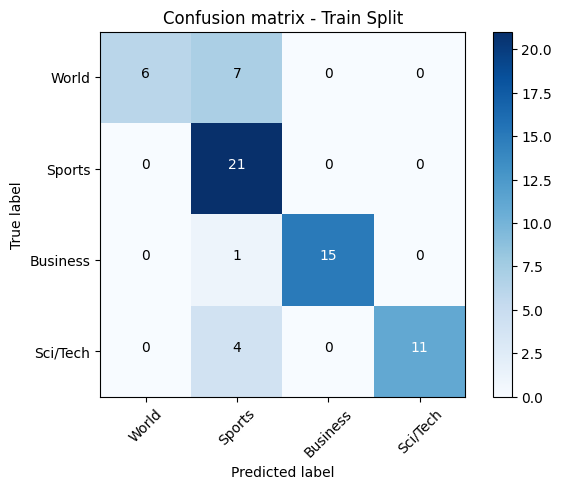

In [8]:
conf = confusion_matrix(counts_train["Label"], predictions_train)

plt.figure()
plot = plot_confusion_matrix(conf, classes = ["World", "Sports", "Business", "Sci/Tech"], title = "Confusion matrix - Train Split")
plt.show()

In [9]:
print("Train Accuracy: ", accuracy_score(counts_train["Label"], predictions_train))

Train Accuracy:  0.8153846153846154


### ...and on the test data

In [10]:
tqdm.pandas(desc = "progress bar")
predictions_test = counts_test.progress_apply(lambda row: NB.predict(row, has_target = True), axis = 1)

progress bar: 100%|████████████████████████████████████████████████████████████████████| 35/35 [01:30<00:00,  2.58s/it]


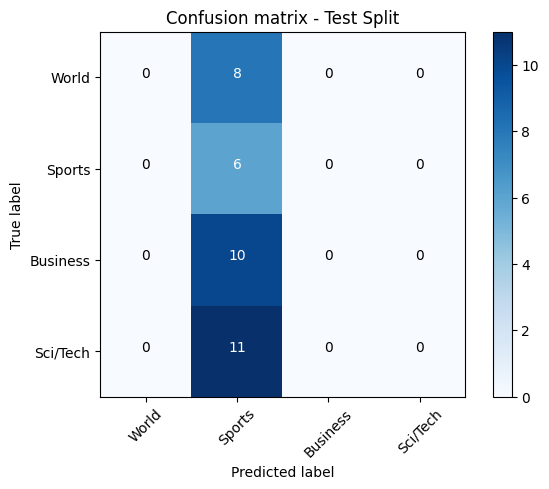

In [11]:
conf = confusion_matrix(counts_test["Label"], predictions_test)

plt.figure()
plot = plot_confusion_matrix(conf, classes = ["World", "Sports", "Business", "Sci/Tech"], title = "Confusion matrix - Test Split")
plt.show()

In [12]:
print("Test Accuracy: ", accuracy_score(counts_test["Label"], predictions_test))

Test Accuracy:  0.17142857142857143


### What can you observe?

Does it work well? What does accuracy in this context mean given that we have four balanced classes (and we assume that our sample is truly random)? What could be pitfalls why the classifier doesn't work well?

### **Alternative/Bonus Exercise:** Implement the kNN algorithm using the TF-IDF matrix representation and using the cosine distance!

Compare (the performance of) your solution to that of the kNN implementation of sklearn: [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)